# Experiment plotting

This notebook contains the code for plotting results for the different experiments.
When run for the first time for a town, condensed summary files are being created which strongly speed up subsequent generations of plots from the same summaries. It is possible to create the plots only from the condensed summaries located in 'summaries/condensed_summaries'.
Note that this works for all experiments but the Rt plots, which still require the full summary file.


In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
import os
import pandas as pd
import pickle
import itertools
from lib.measures import *
from lib.experiment import Experiment, Plot, Result, get_properties, load_summary_list, load_summary
from lib.data import collect_data_from_df
from lib.calibrationSettings import calibration_lockdown_dates, calibration_start_dates, calibration_mob_paths
from lib.calibrationFunctions import get_calibrated_params, downsample_cases
import lib.plot as lib_plot
from lib.plot import Plotter
import matplotlib.pyplot as plt
from lib.summary import load_condensed_summary, get_tracing_probability
from matplotlib import colors

In [12]:
commithash = 'a1d7d05'

# Reduction of different quantities compared to baseline

In [30]:
a = defaultdict(lambda: False)
a['a']= True
a['a']

True

In [23]:
def get_path_siteinfo(mode, commithash, p_adoption=None, beacon_proportion=None, isolation_cap=None):
    country = 'GER'
    area = 'TU'
    
    if mode == 'PanCast':
        path = (f'PanCast/pancast-tracing-siteinfo-{country}-{area}-{commithash}/'
            f'pancast-tracing-siteinfo-{country}-{area}'
            f'-p_adoption={p_adoption}'
            f'-beacon_proportion={beacon_proportion}'
            f'-beacon_mode=visit_freq'
            f'-p2p_beacon=False'
            f'-p_recall=0.0'
            f'-p_manual_reachability=0.0'
            f'-beta_dispersion=True'
            f'-isolation_cap={isolation_cap}'
            f'.pk')
        
    elif mode == 'SPECTs':
        path = (f'PanCast/spect-tracing-siteinfo-{country}-{area}-{commithash}/'
                  f'spect-tracing-siteinfo-{country}-{area}'
                  f'-p_adoption={p_adoption}'
                  f'-p_recall=0.0'
                  f'-p_manual_reachability=0.0'
                  f'-beta_dispersion=True'
                  f'-isolation_cap={isolation_cap}'
                  f'.pk')
        
    elif mode == 'baseline':
        path = (f'PanCast/spect-tracing-siteinfo-{country}-{area}-{commithash}/'
                  f'spect-tracing-siteinfo-{country}-{area}'
                  f'-p_adoption=0.0'
                  f'-p_recall=0.0'
                  f'-p_manual_reachability=0.0'
                  f'-beta_dispersion=True'
                  f'-isolation_cap=0.1'
                  f'.pk')
    return path

get_path_siteinfo(mode, commithash, p_adoption, beacon_proportion, isolation_cap)

NameError: name 'p_adoption' is not defined

FileNotFoundError: [Errno 2] No such file or directory: 'condensed_summaries/PanCast/spect-tracing-siteinfo-GER-TU-a1d7d05/spect-tracing-siteinfo-GER-TU-p_adoption=0.0-p_recall=0.0-p_manual_reachability=0.0-beta_dispersion=True-isolation_cap=0.1_condensed.pk'

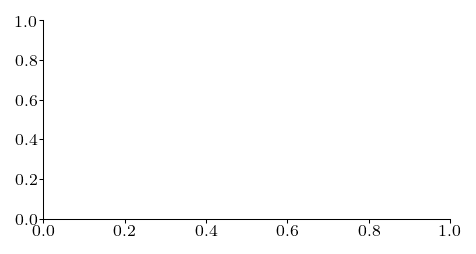

In [18]:
def plot_relative_reduction(*, country, area, mode, ps_adoption, beacon_proportions, isolation_cap,
                            show_reduction=True,  
                            ylim=None, commithash=None):
        
    if mode == 'r_eff':
        if area == 'TU':
            from lib.settings.town_settings_tubingen import town_population
        else:
            raise NotImplementedError('Specify town population')
    else:
        town_population = None
        

    if ylim is None:
        if mode == 'r_eff' and show_reduction:
            ylim = (0.0, 50)
        elif mode == 'r_eff' and not show_reduction:
            ylim= (1.0, 3.5)
            
    
    
    plot_filename = (f'comparison-{mode}-{country}-{area}'
                    f'beta_dispersion'
                    f'-reduction={show_reduction}'
                    f'-beacon_mode=visit-freq'
                    f'-manual_tracing=False')
    paths = [
                [get_path_siteinfo(mode='SPECTs', 
                                   commithash=commithash, 
                                   p_adoption=p_adoption, 
                                   beacon_proportion=None, 
                                   isolation_cap=isolation_cap) for p_adoption in ps_adoption]
            ]
    titles = ['SPECTs']
    
    for beacon_proportion in beacon_proportions:
        paths.append([get_path_siteinfo(mode='PanCast', 
                                   commithash=commithash, 
                                   p_adoption=p_adoption, 
                                   beacon_proportion=beacon_proportion, 
                                   isolation_cap=isolation_cap) for p_adoption in ps_adoption])
                     
        titles.append(f'PanCast, beacons at {int(beacon_proportion*100)}\% of sites')

        
    baseline_path = get_path_siteinfo(mode='baseline', commithash=commithash)

    plotter = Plotter()
    plotter.compare_peak_reduction(path_list=paths, 
                                   baseline_path=baseline_path, 
                                   ps_adoption=ps_adoption,
                                   area_population=town_population,
                                   titles=titles,
                                   mode=mode,
                                   show_reduction=show_reduction,
                                   log_xscale=True,
                                   ylim=ylim,
                                   filename=plot_filename,
                                   figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
                                   figformat='neurips-double',
                                   legend_is_left=True)

              
plot_relative_reduction(
    country='GER', 
    area='TU', 
    mode='cumu_infected',   # Allowed values ['cumu_infected', 'hosp', 'dead', 'r_eff']
    ps_adoption=[1.0, 0.5, 0.25, 0.1, 0.05],
    beacon_proportions=[1.0, 0.25, 0.1, 0.05],#, 0.02],
    show_reduction=True,
    isolation_cap=0.1,
    commithash=commithash
)

# Quantities over time

Extracting data from summary: PanCast/pancast-tracing-siteinfo-GER-TU-a1d7d05/pancast-tracing-siteinfo-GER-TU-p_adoption=0.25-beacon_proportion=0.25-beacon_mode=visit_freq-p2p_beacon=False-p_recall=0.0-p_manual_reachability=0.0-beta_dispersion=True-isolation_cap=0.1.pk


FileNotFoundError: [Errno 2] No such file or directory: 'summaries/PanCast/pancast-tracing-siteinfo-GER-TU-a1d7d05/pancast-tracing-siteinfo-GER-TU-p_adoption=0.25-beacon_proportion=0.25-beacon_mode=visit_freq-p2p_beacon=False-p_recall=0.0-p_manual_reachability=0.0-beta_dispersion=True-isolation_cap=0.1.pk'

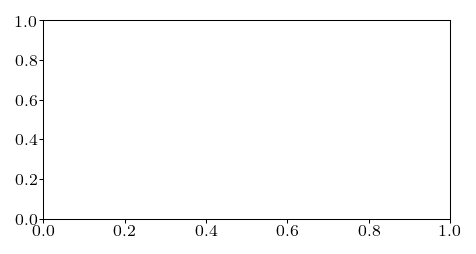

In [19]:
def plot_experiment_over_time(*, country, area, quantity, mode, ymax, 
                              p_adoption=0.25, beacon_proportion=0.05, isolation_cap=0.1):


    paths = [get_path_siteinfo(mode='PanCast', 
                               commithash=commithash, 
                               p_adoption=p_adoption, 
                               beacon_proportion=beacon_proportion, 
                               isolation_cap=isolation_cap),

            get_path_siteinfo(mode='SPECTs', 
                               commithash=commithash, 
                               p_adoption=p_adoption, 
                               beacon_proportion=beacon_proportion, 
                               isolation_cap=isolation_cap),
             
             get_path_siteinfo(mode='baseline', 
                               commithash=commithash)
            ]
    
    labels = [
              f'PanCast, {int(p_adoption*100)}\% adoption, {int(beacon_proportion*100)}\% beacons',
              f'SPECTs, {int(p_adoption*100)}\% adoption',
              f'No measures',
             ]
    
    plot_filename = f'siteinfo-{mode}-{quantity}_over_time-{country}-{area}'
    plotter = Plotter()

    plotter.compare_quantity(
        paths, 
        titles=labels,
        quantity=quantity,
        mode=mode,
        ymax=ymax,
        filename=plot_filename, 
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figformat='neurips-double',
        legend_is_left=True)
    
    
    
plot_experiment_over_time(
    country='GER', 
    area='TU',
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=20000, 
    p_adoption=0.25,
    beacon_proportion=0.25,
)

# Rt over time

In [22]:
def plot_rt_over_time(*, country, area, ps_adoption, mode='spects', beacon_proportion=None, isolation_cap=0.1,
                      commithash='c005255'):
        
    p_recall = 0.0
    p_manual_reachability = 0.0
        
        
    if mode == 'spects':
        plots = {
            f'spect-tracing-siteinfo-p_adoption={p_adoption}-isolation-cap={isolation_cap}' : [
                Plot(label='{:3.0f}\% adoption'.format(100 * p_adoption),
                    path=get_path_siteinfo(mode='SPECTs', 
                                           commithash=commithash, 
                                           p_adoption=p_adoption, 
                                           beacon_proportion=beacon_proportion, 
                                           isolation_cap=isolation_cap))
            ]
            for p_adoption in ps_adoption
        }
        labels = [f'SPECTs, {int(p_adoption*100)}\% adoption' for p_adoption in ps_adoption]
        labels = [f'SPECTs']
    elif mode == 'baselines':
        plots = {
            f'baseline_without_manual' :[
            Plot(label='no_manual',
                path=get_path_siteinfo(mode='baseline', commithash=commithash))],
        }
        labels = ['Baseline without MT']
    elif mode == 'pancast':
        plots = {
            f'pancast-tracing-siteinfo-p_adoption={p_adoption}-beacons={beacon_proportion}-isolation-cap={isolation_cap}': [
                Plot(label='{:3.0f}\% adoption'.format(100 * p_adoption),
                    path=get_path_siteinfo(mode='PanCast', 
                                           commithash=commithash, 
                                           p_adoption=p_adoption, 
                                           beacon_proportion=beacon_proportion, 
                                           isolation_cap=isolation_cap))
            ]
            for p_adoption in ps_adoption
        }
        labels = [f'PanCast, {int(p_adoption*100)}\% adoption, {int(beacon_proportion*100)}\% beacons' for p_adoption in ps_adoption]
        labels = [f'PanCast, {int(beacon_proportion*100)}\% beacons']
    
    for i, (plot_filename, plots) in enumerate(plots.items()):

        # extract plot info
        # labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')
        path = paths[0]
        
        # plot
        plotter = Plotter()
        plotter.plot_daily_nbinom_rts(
            path=path, 
            filename=plot_filename,
            cmap_range=(0.5, 1.5),
            figsize=lib_plot.FIG_SIZE_NEURIPS_TRIPLE,
            figformat='neurips-double',
            ymax=3.3,
            label=labels[i],
            #xlim=(0, 185),
            x_axis_dates=False,
            subplots_adjust={'bottom':0.2, 'top': 0.98, 'left': 0.12, 'right': 0.96},
        )
          

modes = ['baselines', 'spects', 'pancast']
for mode in modes:
    plot_rt_over_time(
        country='GER', 
        area='TU', 
        ps_adoption=[0.25],#, 0.5, 0.25, 0.1, 0.05, 0.0],
        mode=mode,
        beacon_proportion=0.25,
        commithash=commithash
    )

# Crop pdf margins
!bash crop_pdfs.sh plots/daily-nbinom-rts-*.pdf
!bash crop_pdfs.sh plots/prob-secondaryCases-*.pdf

FileNotFoundError: [Errno 2] No such file or directory: 'condensed_summaries/PanCast/spect-tracing-siteinfo-GER-TU-a1d7d05/spect-tracing-siteinfo-GER-TU-p_adoption=0.0-p_recall=0.0-p_manual_reachability=0.0-beta_dispersion=True-isolation_cap=0.1_condensed.pk'